In [ ]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

import scipy.io as sio
import numpy as np
from datetime import datetime
from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.BDLM_trainer import BDLM_trainer
from examples.data_loader import TimeSeriesDataloader, SyntheticTimeSeriesDataloader
from pytagi.hybrid import *
from pytagi.nn import LSTM, Linear, OutputUpdater, Sequential
from pytagi import Normalizer as normalizer
from matplotlib import gridspec
from scipy.stats import norm

In [2]:
# Import data HQ TS2
time_series_path = './data/synthetic/observation.csv'
# Load csv, no header
y_disp = pd.read_csv(time_series_path, header=None)[0].tolist()
timestamps = pd.date_range(start='1/1/2020', periods=len(y_disp), freq='W')
time_covariates = ['week_of_year']

In [3]:
num_epochs: int = 30
batch_size: int = 1
sigma_v: float = 1E-12

"""Run training for time-series forecasting model"""
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

anm_pos = 100

In [4]:
train_dtl = TimeSeriesDataloader(
                            x_file = 'data/synthetic/ytrain_obs.csv',
                            date_time_file = 'data/synthetic/ytrain_datetime.csv',
                            output_col = output_col,
                            input_seq_len = input_seq_len,
                            output_seq_len = output_seq_len,
                            num_features = num_features,
                            stride = seq_stride,
                            time_covariates = time_covariates,  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
                        )

test_dtl = TimeSeriesDataloader(
                            x_file = 'data/synthetic/ytest_obs.csv',
                            date_time_file = 'data/synthetic/ytest_datetime.csv',
                            output_col = output_col,
                            input_seq_len = input_seq_len,
                            output_seq_len = output_seq_len,
                            num_features = num_features,
                            stride = seq_stride,
                            x_mean = train_dtl.x_mean,
                            x_std = train_dtl.x_std,
                            time_covariates = time_covariates,  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
                        )

train_val_dtl = TimeSeriesDataloader(
                            x_file = 'data/synthetic/ytrain_yval_obs.csv',
                            date_time_file = 'data/synthetic/ytrain_yval_datetime.csv',
                            output_col = output_col,
                            input_seq_len = input_seq_len,
                            output_seq_len = output_seq_len,
                            num_features = num_features,
                            stride = seq_stride,
                            add_anomaly = True,
                            anomaly_magnitude=0.02,
                            anomaly_start= anm_pos + input_seq_len,
                            x_mean = train_dtl.x_mean,
                            x_std = train_dtl.x_std,
                            time_covariates = time_covariates,  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
                        )

In [5]:
batch_iter = train_val_dtl.create_data_loader(batch_size, shuffle=False)

model_path = './saved_param/synthetic/lstm_test1.pth'
net_test = Sequential(
    LSTM(num_features, 30, input_seq_len),
    LSTM(30, 30, input_seq_len),
    Linear(30 * input_seq_len, 1),
)
net_test.set_threads(8)
net_test.load(filename = model_path)


initial_z = np.array([0.26, 0.0005, 0, 0, 0.02])
initial_Sz = np.array([1E-5, 1E-8, 1e-20, 1e-20, 0.15**2])
# initial_z = (np.array([0.02028447583121533, -0.0001847171265765491, 0, 0, 0.02])  - train_dtl.x_mean[output_col]) / (train_dtl.x_std[output_col] + 1e-10)
# initial_Sz = np.array([1E-5, 1E-8, 1e-20, 1e-20, 0.15**2]) / (train_dtl.x_std[output_col] + 1e-10) ** 2
phi_AR = 0.871505143847883
Sigma_AR = 0.03275577237587235
var_phi_AR = 0.0008671138875746663
var_Sigma_AR = 2.6628888745464738e-05

hybrid_test = LSTM_SSM(
                neural_network = net_test,           # LSTM
                baseline = 'LT + BAR + ITV + AR_fixed', # 'level', 'trend', 'acceleration', 'ETS'
                zB  = initial_z,
                SzB = initial_Sz,
                phi_AR = phi_AR,
                Sigma_AR = Sigma_AR,
                Sigma_AA_ratio = 1e-14,
                phi_AA = 0.999,
                use_auto_AR = False,
                use_BAR = True,
                input_BAR = [2, -2, 2],
            )

mu_lstm = []
var_lstm = []
obs_norm = []
mu_preds_norm = []
var_preds_norm = []
mu_LL = []
var_LL = []
mu_AR = []
var_AR = []
mu_lstm = []
var_lstm = []

total_reward = 0
gamma_val = 0.99
mean_R = 0.157579007610389
std_R = 0.6997088860885404
cost_itv = 1*(mean_R + std_R)/(1-gamma_val)

var_y = np.full((batch_size * len(output_col),), sigma_v**2, dtype=np.float32)
hybrid_test.init_ssm_hs()
env_step = 0

for x, y in batch_iter:
    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_lstm, var_preds_lstm = var_lstm,
        input_seq_len = input_seq_len, num_features = num_features,
        )

    # Feed forward
    y_pred, Sy_pred, z_pred, Sz_pred, m_pred, v_pred = hybrid_test(mu_x, var_x)
    # Backward
    z_update, Sz_update = hybrid_test.backward(mu_obs = y, var_obs = var_y, train_LSTM = False)

    if env_step == anm_pos + 50:
        action = 1
    else:
        action = 0

    if action == 1:
        # Use intervention estimation to infer the baseline model
        mu_baseline = z_update[:2]
        cov_baseline = Sz_update[:2, :2]
        LT_F = hybrid_test.F[:,:2]
        mu_baseline_pred = LT_F @ mu_baseline
        cov_baseline_pred = LT_F @ cov_baseline @ LT_F.T
        # Add delta to baseline_pred
        # mu_baseline_target = mu_baseline_pred + z_update[3]
        # cov_baseline_target = cov_baseline_pred + Sz_update[3, 3] + 2 * Sz_update[3, 0]
        mu_baseline_target = mu_baseline_pred + z_update[-2]
        cov_baseline_target = cov_baseline_pred + Sz_update[-2, -2] + 2 * Sz_update[-2, 0]
        # Infer baseline components
        J = cov_baseline @ LT_F.T / cov_baseline_pred
        z_update[:2] = mu_baseline + J @ (mu_baseline_target - mu_baseline_pred)
        Sz_update[:2, :2] = cov_baseline + J @ (cov_baseline_target - cov_baseline_pred) @ J.T
        # Exclude the intervention component from AR at position -2
        # z_update[-2] -= z_update[3]
        # Sz_update[-2, -2] = Sz_update[-2, -2] + Sz_update[3, 3] + 2 * Sz_update[3, -2]
        z_update[-2] -= z_update[-2]
        Sz_update[-2, -2] = Sz_update[-2, -2] + Sz_update[-2, -2] + 2 * Sz_update[-2, -2]
        hybrid_test.z = z_update
        hybrid_test.Sz = Sz_update
        hybrid_test.Sz[1, 1] = hybrid_test.Sz[0, 0]

    y_unnorm = normalizer.unstandardize(
            y, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        )
    
    # Rewards
    if np.isnan(y):
        likelihood = norm.pdf(y_pred, loc=y_pred, scale=np.sqrt(Sy_pred))
    else:
        # # Option 1: Likelihood
        likelihood = norm.pdf(y, loc=y_pred, scale=np.sqrt(Sy_pred))

        # # Option 2: Conditional likelihood
        # samples_y_plus_ARW = np.random.normal(0, np.sqrt(Sigma_AR), 100) + y_pred
        # Sy_pred_exclude_ARW = Sy_pred - Sigma_AR
        # likelihood_samples = norm.pdf(y, loc=samples_y_plus_ARW, scale=np.sqrt(Sy_pred_exclude_ARW))
        # likelihood = np.mean(likelihood_samples)

    if action == 1:
        reward = likelihood - cost_itv
    else:
        reward = likelihood

    total_reward += np.sum(reward)
    
    obs_norm.extend(y)
    mu_preds_norm.extend(y_pred[0])
    var_preds_norm.extend(Sy_pred[0] + sigma_v**2)
    mu_LL.append(z_pred[0].item())
    var_LL.append(Sz_pred[0][0])
    mu_AR.append(z_pred[-2].item())
    var_AR.append(Sz_pred[-2][-2])
    mu_lstm.extend(m_pred)
    var_lstm.extend(v_pred)

    env_step += 1

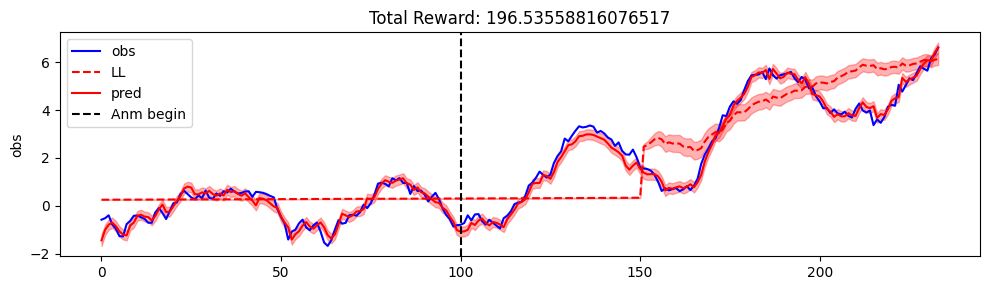

In [6]:
AR_var_stationary = Sigma_AR /(1-phi_AR**2)
fig = plt.figure(figsize=(10, 3))
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
# ax1 = plt.subplot(gs[1])
# ax2 = plt.subplot(gs[2])
# ax3 = plt.subplot(gs[3])
# ax4 = plt.subplot(gs[4])

ax0.plot(np.arange(len(obs_norm)),obs_norm,color='b',label=r"obs")
ax0.plot(np.arange(len(mu_LL)),mu_LL,'--',color='r',label=r"LL")
ax0.fill_between(np.arange(len(mu_LL)), np.array(mu_LL) - np.sqrt(var_LL), np.array(mu_LL) + np.sqrt(var_LL), color='red', alpha=0.3)
ax0.plot(np.arange(len(mu_preds_norm)),mu_preds_norm,color='r',label=r"pred")
ax0.fill_between(np.arange(len(mu_preds_norm)), np.array(mu_preds_norm) - np.sqrt(var_preds_norm), np.array(mu_preds_norm) + np.sqrt(var_preds_norm), color='red', alpha=0.3)
ax0.axvline(x=anm_pos, color='black', linestyle='--', label='Anm begin')
ax0.set_ylabel('obs')
ax0.legend()

ax0.set_title('Total Reward: {}'.format(total_reward))

plt.show()

# Check agents

In [7]:
from pytagi.LSTM_KF_RL_Env import LSTM_KF_Env
import torch
from src.RL_functions.helpers import *
from pytagi.nn import Linear, OutputUpdater, ReLU, Sequential, EvenExp

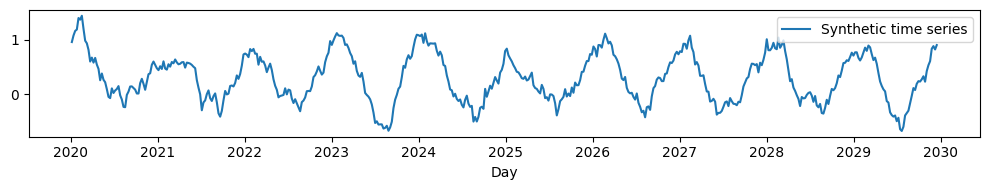

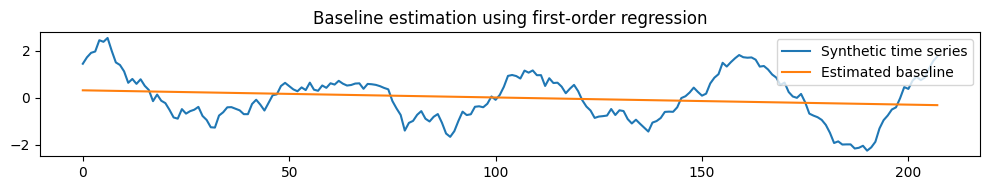

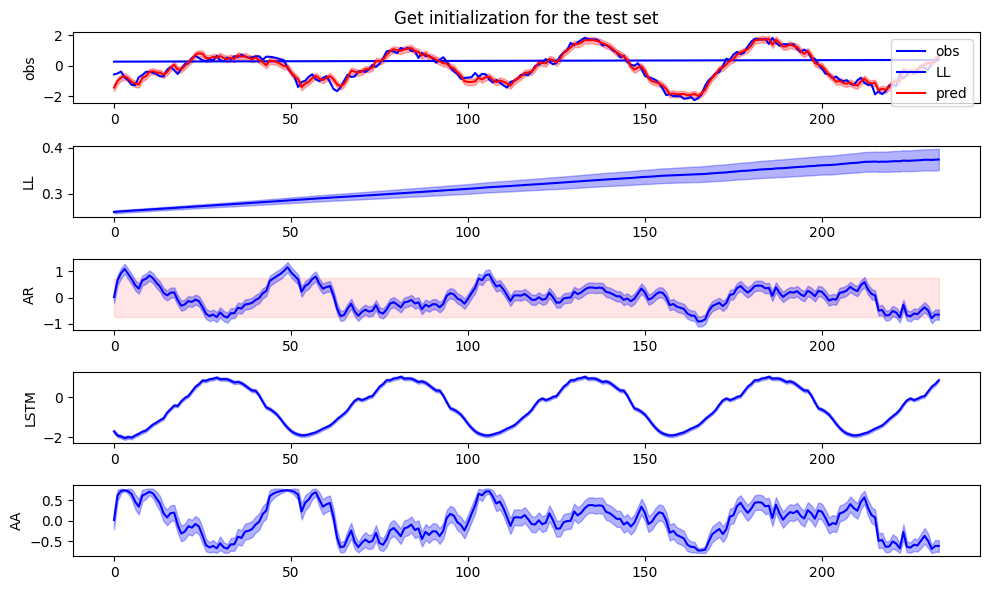

In [8]:
obs_file_paths = ['data/synthetic/ytrain_obs.csv', 'data/synthetic/yval_obs.csv', 'data/synthetic/ytest_obs.csv']
date_file_paths=['data/synthetic/ytrain_datetime.csv', 'data/synthetic/yval_datetime.csv', 'data/synthetic/ytest_datetime.csv']

data_preprocessor = generate_one_synthetic_time_series(used_for_generation=False)
data_preprocessor.time_series['y'] = y_disp
data_preprocessor.time_series['timesteps'] = timestamps
data_preprocessor.time_step_interval = 7
data_preprocessor.export_to_csv(indices_train_val_test=[4*52, 5*52, -1],
                     observation_file_paths = obs_file_paths,
                     datetime_file_paths=date_file_paths,
                     start_datetime=datetime(2012, 1, 15, 12, 0, 0))
val_datetime_values = data_preprocessor.get_validation_datetime_values()
data_preprocessor.plot()

BDLM = BDLM_trainer(num_epochs=num_epochs,
                    batch_size=batch_size,
                    sigma_v=sigma_v,
                    output_col=output_col,
                    num_features=num_features,
                    components = 'LT + BAR + ITV + AR',
                    use_BAR = True,
                    input_BAR = [2, -2, 2],
                    input_seq_len=input_seq_len,
                    output_seq_len=output_seq_len,
                    seq_stride=seq_stride)
BDLM.load_datasets(obs_file_paths, date_file_paths, time_covariates)
BDLM.estimate_initial_baseline(plot=True)

BDLM.phi_AR = 0.871505143847883
BDLM.Sigma_AR = 0.03275577237587235
BDLM.var_phi_AR = 0.0008671138875746663
BDLM.var_Sigma_AR = 2.6628888745464738e-05
BDLM.load_LSTM_model(path = './saved_param/synthetic/lstm_test1.pth')

initial_z = np.array([0.26, 0.0005, 0, 0, 0.02])
initial_Sz = np.array([1E-5, 1E-8, 1e-20, 1e-20, 0.15**2])
LSTM_net, init_mu_lstm, init_var_lstm, init_z, init_Sz, init_mu_W2b, init_var_W2b,\
last_seq_obs, last_seq_datetime, last_lstm_x = BDLM.get_testing_model_initials(val_datetime_values=val_datetime_values, plot=True,
                                                                               initial_z = initial_z, initial_Sz = initial_Sz)

In [9]:
class TAGI_Net():
    def __init__(self, n_observations, n_actions):
        super(TAGI_Net, self).__init__()
        self.net = Sequential(
                    # Linear(n_observations, 32),
                    Linear(n_observations+1, 32, gain_weight=0.5, gain_bias=0.5),
                    ReLU(),
                    # Linear(32, 32),
                    Linear(32, 32, gain_weight=0.5, gain_bias=0.5),
                    ReLU(),
                    # Linear(32, n_actions * 2),
                    Linear(32, n_actions * 2, gain_weight=0.5, gain_bias=0.5),
                    EvenExp()
                    )
        self.n_actions = n_actions
        self.n_observations = n_observations
    def forward(self, mu_x, var_x):
        return self.net.forward(mu_x, var_x)

In [10]:
def _select_action(state, policy_net, greedy = False):
        policy_net.net.eval()
        state_np = state.numpy()

        state_temp = np.array(state_np)
        state_np = np.repeat(state_temp, batch_size, axis=0)

        ma, Sa = policy_net.net(state_np)
        ma = ma.reshape(batch_size, policy_net.n_actions*2)[0]
        action_mean = ma[::2]
        Sa = Sa.reshape(batch_size, policy_net.n_actions*2)[0]

        action_var = Sa[::2] + ma[1::2]
        # action = np.argmax(np.array(action_mean) - np.sqrt(action_var), axis=0)
        action = np.argmax(np.array(action_mean), axis=0)

        # # Use P(a1-a0)>0.5 as the criterion
        # if scipy.stats.norm.cdf((ma[::2][1]-ma[::2][0])/np.sqrt(Sa[::2][0] + Sa[::2][1]))>0.5:
        #     action = 1
        # else:
        #     action = 0

        return torch.tensor([[action]],device='cpu')

def _track_Qvalues(state, policy_net):
        policy_net.net.eval()
        state_np = state.numpy()
        Q_values_f,var_Q_val_f = policy_net.net(state_np)
        Q_values = Q_values_f[::2]
        var_Q_val = var_Q_val_f[::2] + Q_values_f[1::2]
        epistemic_uncertainty = var_Q_val_f[::2]
        aleatory_uncertainty = Q_values_f[1::2]
        return [Q_values], [var_Q_val], [epistemic_uncertainty], [aleatory_uncertainty]

In [11]:
def _test_real_data(i_episode, policy_net, init_z, init_Sz, init_mu_preds_lstm, init_var_preds_lstm, score):
    from itertools import count

    step_look_back = 64
    env = LSTM_KF_Env(render_mode=None, data_loader=test_dtl, \
                        ts_model=hybrid_test, step_look_back=step_look_back)

    state, _ = env.reset(z=init_z, Sz=init_Sz, mu_preds_lstm = copy.deepcopy(init_mu_preds_lstm), var_preds_lstm = copy.deepcopy(init_var_preds_lstm),
                            net_test = net_test, init_mu_W2b = None, init_var_W2b = None, phi_AR=hybrid_test.phi_AR, Sigma_AR=hybrid_test.Sigma_AR,
                            phi_AA = hybrid_test.phi_AA, Sigma_AA_ratio = hybrid_test.Sigma_AA_ratio, use_BAR = hybrid_test.use_BAR, input_BAR = hybrid_test.input_BAR)

    intervention_index =[]
    LA_var_stationary = hybrid_test.Sigma_AA_ratio *  hybrid_test.Sigma_AR/(1 - hybrid_test.phi_AA**2)
    AR_std_stationary = np.sqrt(hybrid_test.Sigma_AR/(1 - hybrid_test.phi_AR**2))
    # if step_look_back == 64:
    seg_len = 8
    RL_step_taken = 0
    Q_values_all = []
    Q_var_all = []
    Q_var_epstic_all = []
    action_triggered_last_64_steps = False
    dummy_steps = 0
    for t in count():
        state = torch.tensor(state['hidden_states'],\
                            dtype=torch.float32, device='cpu').unsqueeze(0)
        state = normalize_tensor_two_parts(state, 0, 1, 0, AR_std_stationary, seg_len)
        if action_triggered_last_64_steps:
            if dummy_steps > 64:
                action_triggered_last_64_steps = False
                state = torch.cat((state, torch.zeros(1, 1, device='cpu')), dim=1)
            else:
                state = torch.cat((state, torch.ones(1, 1, device='cpu')), dim=1)
                dummy_steps += 1
        else:
            state = torch.cat((state, torch.zeros(1, 1, device='cpu')), dim=1)

        # Select action
        action = _select_action(state, policy_net, greedy=True)
        # Track Q values
        Q_values_t, Q_var_t, epist_var_Q, alea_var_Q  = _track_Qvalues(state, policy_net)
        Q_values_t = Q_values_t[0].tolist()
        Q_var_t = Q_var_t[0].tolist()
        epist_var_Q = epist_var_Q[0].tolist()
        Q_values_all.append(Q_values_t)
        Q_var_all.append(Q_var_t)
        Q_var_epstic_all.append(epist_var_Q)

        state, _, terminated, truncated, info = env.step(action.item(), cost_intervention=cost_itv)

        RL_step_taken += 1

        if action.item() == 1:
            intervention_index.append(t + step_look_back + 1)
            action_triggered_last_64_steps = True

        done = terminated or truncated
        if done:
            break

    # Fill 65 rows of [nan, nan] values in front of Q_values_all
    Q_values_all = [[np.nan, np.nan]] * 65 + Q_values_all
    Q_values_all = np.array(Q_values_all).T
    Q_var_all = [[np.nan, np.nan]] * 65 + Q_var_all
    Q_var_all = np.array(Q_var_all).T
    Q_var_epstic_all = [[np.nan, np.nan]] * 65 + Q_var_epstic_all
    Q_var_epstic_all = np.array(Q_var_epstic_all).T

    # Compute P(a1-a0)
    p_a1 = scipy.stats.norm.cdf((Q_values_all[1]-Q_values_all[0])/np.sqrt(Q_var_epstic_all[0] + Q_var_epstic_all[1]))

    # Plot prediction
    timesteps = np.arange(0, len(info['measurement_one_episode']), 1)
    mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
    var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
    mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
    var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()
    from matplotlib import gridspec
    fig = plt.figure(figsize=(15, 14))
    gs = gridspec.GridSpec(6, 1)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[3])
    ax3 = plt.subplot(gs[4])
    ax4 = plt.subplot(gs[5])
    ax5 = plt.subplot(gs[1])

    ax0.plot(timesteps, info['measurement_one_episode'], label='True')
    ax0.plot(timesteps, mu_prediction_one_episode , label='Predicted')
    for count, i in enumerate(intervention_index):
        if count == 0:
            ax0.axvline(x=timesteps[i], color='r', linestyle='--', label='RL triggers')
        else:
            ax0.axvline(x=timesteps[i], color='r', linestyle='--')
    ax0.plot(timesteps, mu_hidden_states_one_episode[:,0], color = 'k',alpha=0.4, label='LL')
    # ax0.fill_between(timesteps, mu_hidden_states_one_episode[:,0] - np.sqrt(var_hidden_states_one_episode[:,0,0]),\
    #                     mu_hidden_states_one_episode[:,0] + np.sqrt(var_hidden_states_one_episode[:,0,0]), color='gray', alpha=0.2)
    ax0.set_ylabel('y')
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.07,1))


    ax1.plot(timesteps, mu_hidden_states_one_episode[:,3], label='ITV')
    ax1.fill_between(timesteps, mu_hidden_states_one_episode[:,3] - np.sqrt(var_hidden_states_one_episode[:,3,3]),\
                        mu_hidden_states_one_episode[:,3] + np.sqrt(var_hidden_states_one_episode[:,3,3]), color='gray', alpha=0.2)
    ax1.set_ylabel('ITV')

    ax2.fill_between(timesteps, np.zeros_like(timesteps)-3*AR_std_stationary, np.zeros_like(timesteps)+3*AR_std_stationary, color='red', alpha=0.1)
    ax2.plot(timesteps, mu_hidden_states_one_episode[:,-2], label='AR')
    ax2.fill_between(timesteps, mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]),\
                        mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]), color='gray', alpha=0.2)
    ax2.set_ylabel('AR')
    # ax2.set_ylim(-1.1, 1.1)

    # ax3.plot(timesteps, mu_hidden_states_one_episode[:,1], label='LT')
    # ax3.fill_between(timesteps, mu_hidden_states_one_episode[:,1] - np.sqrt(var_hidden_states_one_episode[:,1,1]),\
    #                     mu_hidden_states_one_episode[:,1] + np.sqrt(var_hidden_states_one_episode[:,1,1]), color='gray', alpha=0.2)
    # ax3.set_ylabel('LT')
    # ax3.set_ylim(-0.1,0.1)
    ax3.plot(timesteps, p_a1, label='P(a1-a0)')
    ax3.set_ylabel('P(a1-a0)')
    ax3.set_ylim(-0.1, 1.1)
    ax3.set_xlim(ax0.get_xlim())

    ax4.plot(timesteps, mu_hidden_states_one_episode[:,-1], label='LSTM')
    ax4.fill_between(timesteps, mu_hidden_states_one_episode[:,-1] - np.sqrt(var_hidden_states_one_episode[:,-1,-1]),\
                        mu_hidden_states_one_episode[:,-1] + np.sqrt(var_hidden_states_one_episode[:,-1,-1]), color='gray', alpha=0.2)
    ax4.set_ylabel('LSTM')
    ax4.set_xlabel('Time steps')

    ax5.plot(timesteps, Q_values_all[0], label='Q(0)')
    ax5.plot(timesteps, Q_values_all[1], label='Q(1)')
    ax5.fill_between(timesteps, Q_values_all[0] - np.sqrt(Q_var_all[0]),\
                        Q_values_all[0] + np.sqrt(Q_var_all[0]), color='gray', alpha=0.2)
    ax5.fill_between(timesteps, Q_values_all[1] - np.sqrt(Q_var_all[1]),\
                        Q_values_all[1] + np.sqrt(Q_var_all[1]), color='gray', alpha=0.2)
    ax5.fill_between(timesteps, Q_values_all[0] - np.sqrt(Q_var_epstic_all[0]),\
                        Q_values_all[0] + np.sqrt(Q_var_epstic_all[0]), color='green', alpha=0.2)
    ax5.fill_between(timesteps, Q_values_all[1] - np.sqrt(Q_var_epstic_all[1]),\
                        Q_values_all[1] + np.sqrt(Q_var_epstic_all[1]), color='green', alpha=0.2)
    ax5.set_ylabel('Q values')
    # set x axis to be the same as ax0
    ax5.set_xlim(ax0.get_xlim())
    ax5.legend(loc='upper center', bbox_to_anchor=(1.07,1))

    ax0.set_title(f'AGENT {i_episode+1}, SCORE = {score :.4f}')

    # save figure to local
    filename = f'saved_results/synthetic/agents100/test_agent#{i_episode+1}.png'
    plt.savefig(filename)
    plt.close()


In [12]:
def _test_validation_syn_data(i_episode, policy_net, anm_magnitudes, anm_positions):
    scores_all = []
    
    from matplotlib import gridspec
    fig = plt.figure(figsize=(15, 14))
    gs = gridspec.GridSpec(len(anm_magnitudes), 1)

    for i in range(len(anm_magnitudes)):
        train_val_dtl = SyntheticTimeSeriesDataloader(
                                x_file = 'data/synthetic/RLDS_y_observation_10episodes_nomixed_V1.csv',
                                date_time_file = 'data/synthetic/RLDS_y_datetime_10episodes_nomixed_V1.csv',
                                select_column = i,
                                output_col = output_col,
                                input_seq_len = input_seq_len,
                                output_seq_len = output_seq_len,
                                num_features = num_features,
                                stride = seq_stride,
                                add_anomaly = True,
                                anomaly_magnitude=anm_magnitudes[i],
                                anomaly_start= anm_positions[i] + input_seq_len,
                                x_mean = train_dtl.x_mean,
                                x_std = train_dtl.x_std,
                                time_covariates = time_covariates,  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
                            )
        
        step_look_back = 64
        env = LSTM_KF_Env(render_mode=None, data_loader=train_val_dtl, \
                            ts_model=hybrid_test, step_look_back=step_look_back)

        state, _ = env.reset(z= np.concatenate((initial_z, np.array([0])), axis=0).reshape(-1,1) , Sz=np.diag(np.concatenate((initial_Sz, np.array([0])), axis=0)) , mu_preds_lstm = [], var_preds_lstm = [],
                                net_test = net_test, init_mu_W2b = None, init_var_W2b = None, phi_AR=hybrid_test.phi_AR, Sigma_AR=hybrid_test.Sigma_AR,
                                phi_AA = hybrid_test.phi_AA, Sigma_AA_ratio = hybrid_test.Sigma_AA_ratio, use_BAR = hybrid_test.use_BAR, input_BAR = hybrid_test.input_BAR)

        intervention_index =[]
        LA_var_stationary = hybrid_test.Sigma_AA_ratio *  hybrid_test.Sigma_AR/(1 - hybrid_test.phi_AA**2)
        AR_std_stationary = np.sqrt(hybrid_test.Sigma_AR/(1 - hybrid_test.phi_AR**2))
        # if step_look_back == 64:
        seg_len = 8
        RL_step_taken = 0
        action_triggered_last_64_steps = False
        total_reward = 0
        dummy_steps = 0
        from itertools import count
        for t in count():
            state = torch.tensor(state['hidden_states'],\
                                dtype=torch.float32, device='cpu').unsqueeze(0)
            state = normalize_tensor_two_parts(state, 0, 1, 0, AR_std_stationary, seg_len)
            if action_triggered_last_64_steps:
                if dummy_steps > 64:
                    action_triggered_last_64_steps = False
                    state = torch.cat((state, torch.zeros(1, 1, device='cpu')), dim=1)
                else:
                    state = torch.cat((state, torch.ones(1, 1, device='cpu')), dim=1)
                    dummy_steps += 1
            else:
                state = torch.cat((state, torch.zeros(1, 1, device='cpu')), dim=1)

            # Select action
            action = _select_action(state, policy_net, greedy=True)

            state, reward, terminated, truncated, info = env.step(action.item(), cost_intervention=cost_itv)

            # Rewards
            if np.isnan(info['measurement_one_episode'][-1]):
                likelihood = norm.pdf(info['prediction_one_episode']['mu'][-1], loc=info['prediction_one_episode']['mu'][-1], scale=np.sqrt(info['prediction_one_episode']['var'][-1]))
            else:
                # # Option 1: Likelihood
                likelihood = norm.pdf(info['measurement_one_episode'][-1], loc=info['prediction_one_episode']['mu'][-1], scale=np.sqrt(info['prediction_one_episode']['var'][-1]))

            # # Include intervention cost in the evaluation
            # if action == 1:
            #     reward = likelihood - cost_itv
            # else:
            #     reward = likelihood

            # # # Exclude intervention cost in the evaluation
            # reward = likelihood

            total_reward += reward

            RL_step_taken += 1

            if action.item() == 1:
                intervention_index.append(t + step_look_back + 1)
                action_triggered_last_64_steps = True

            done = terminated or truncated
            if done:
                break
        scores_all.append(total_reward)

        timesteps = np.arange(0, len(info['measurement_one_episode']), 1)
        mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
        var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
        mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
        var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()

        ax = plt.subplot(gs[i])
        ax.plot(timesteps, info['measurement_one_episode'], label='True')
        ax.plot(timesteps, mu_prediction_one_episode , label='Predicted')
        ax.fill_between(timesteps, mu_prediction_one_episode - np.sqrt(var_prediction_one_episode),\
                            mu_prediction_one_episode + np.sqrt(var_prediction_one_episode), color='gray', alpha=0.2)
        ax.axvline(x=anm_positions[i], color='black', linestyle='--', label='Anm begin')
        for count, i in enumerate(intervention_index):
            if count == 0:
                ax.axvline(x=timesteps[i], color='r', linestyle='--', label='RL triggers')
            else:
                ax.axvline(x=timesteps[i], color='r', linestyle='--')

        ax.plot(timesteps, mu_hidden_states_one_episode[:,0], color = 'k',alpha=0.4, label='LL')
        ax.fill_between(timesteps, mu_hidden_states_one_episode[:,0] - np.sqrt(var_hidden_states_one_episode[:,0,0]),\
                            mu_hidden_states_one_episode[:,0] + np.sqrt(var_hidden_states_one_episode[:,0,0]), color='gray', alpha=0.2)
        ax.set_ylabel('y')
        handles, labels = ax.get_legend_handles_labels()
        # ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.07,1))

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'AGENT {(i_episode+1)*10}, SCORE = {np.mean(scores_all) :.4f}')
    # save figure to local
    filename = f'saved_results/synthetic/agents100/val_syn_agent#{(i_episode+1)*10}.png'
    plt.savefig(filename)
    plt.close()

    return np.mean(scores_all)

In [13]:
def _test_validation_data(i_episode, policy_net, anm_magnitudes, anm_positions):
    scores_all = []
    
    from matplotlib import gridspec
    fig = plt.figure(figsize=(15, 14))
    gs = gridspec.GridSpec(len(anm_magnitudes), 1)

    for i in range(len(anm_magnitudes)):
        train_val_dtl = SyntheticTimeSeriesDataloader(
                                x_file = 'data/synthetic/ytrain_yval_obs.csv',
                                date_time_file = 'data/synthetic/ytrain_yval_datetime.csv',
                                output_col = output_col,
                                input_seq_len = input_seq_len,
                                output_seq_len = output_seq_len,
                                num_features = num_features,
                                stride = seq_stride,
                                add_anomaly = True,
                                anomaly_magnitude=anm_magnitudes[i],
                                anomaly_start= anm_positions[i] + input_seq_len,
                                x_mean = train_dtl.x_mean,
                                x_std = train_dtl.x_std,
                                time_covariates = time_covariates,  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
                            )
        
        step_look_back = 64
        env = LSTM_KF_Env(render_mode=None, data_loader=train_val_dtl, \
                            ts_model=hybrid_test, step_look_back=step_look_back)

        state, _ = env.reset(z= np.concatenate((initial_z, np.array([0])), axis=0).reshape(-1,1) , Sz=np.diag(np.concatenate((initial_Sz, np.array([0])), axis=0)) , mu_preds_lstm = [], var_preds_lstm = [],
                                net_test = net_test, init_mu_W2b = None, init_var_W2b = None, phi_AR=hybrid_test.phi_AR, Sigma_AR=hybrid_test.Sigma_AR,
                                phi_AA = hybrid_test.phi_AA, Sigma_AA_ratio = hybrid_test.Sigma_AA_ratio, use_BAR = hybrid_test.use_BAR, input_BAR = hybrid_test.input_BAR)

        intervention_index =[]
        LA_var_stationary = hybrid_test.Sigma_AA_ratio *  hybrid_test.Sigma_AR/(1 - hybrid_test.phi_AA**2)
        AR_std_stationary = np.sqrt(hybrid_test.Sigma_AR/(1 - hybrid_test.phi_AR**2))
        # if step_look_back == 64:
        seg_len = 8
        RL_step_taken = 0
        action_triggered_last_64_steps = False
        total_reward = 0
        dummy_steps = 0
        from itertools import count
        for t in count():
            state = torch.tensor(state['hidden_states'],\
                                dtype=torch.float32, device='cpu').unsqueeze(0)
            state = normalize_tensor_two_parts(state, 0, 1, 0, AR_std_stationary, seg_len)
            if action_triggered_last_64_steps:
                if dummy_steps > 64:
                    action_triggered_last_64_steps = False
                    state = torch.cat((state, torch.zeros(1, 1, device='cpu')), dim=1)
                else:
                    state = torch.cat((state, torch.ones(1, 1, device='cpu')), dim=1)
                    dummy_steps += 1
            else:
                state = torch.cat((state, torch.zeros(1, 1, device='cpu')), dim=1)

            # Select action
            action = _select_action(state, policy_net, greedy=True)

            state, reward, terminated, truncated, info = env.step(action.item(), cost_intervention=cost_itv)

            # Rewards
            if np.isnan(info['measurement_one_episode'][-1]):
                likelihood = norm.pdf(info['prediction_one_episode']['mu'][-1], loc=info['prediction_one_episode']['mu'][-1], scale=np.sqrt(info['prediction_one_episode']['var'][-1]))
            else:
                # # Option 1: Likelihood
                likelihood = norm.pdf(info['measurement_one_episode'][-1], loc=info['prediction_one_episode']['mu'][-1], scale=np.sqrt(info['prediction_one_episode']['var'][-1]))

            # # Include intervention cost in the evaluation
            # if action == 1:
            #     reward = likelihood - cost_itv
            # else:
            #     reward = likelihood

            # # # Exclude intervention cost in the evaluation
            # reward = likelihood

            total_reward += reward

            RL_step_taken += 1

            if action.item() == 1:
                intervention_index.append(t + step_look_back + 1)
                action_triggered_last_64_steps = True

            done = terminated or truncated
            if done:
                break
        scores_all.append(total_reward)

        timesteps = np.arange(0, len(info['measurement_one_episode']), 1)
        mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
        var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
        mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
        var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()

        ax = plt.subplot(gs[i])
        ax.plot(timesteps, info['measurement_one_episode'], label='True')
        ax.plot(timesteps, mu_prediction_one_episode , label='Predicted')
        ax.fill_between(timesteps, mu_prediction_one_episode - np.sqrt(var_prediction_one_episode),\
                            mu_prediction_one_episode + np.sqrt(var_prediction_one_episode), color='gray', alpha=0.2)
        ax.axvline(x=anm_positions[i], color='black', linestyle='--', label='Anm begin')
        for count, i in enumerate(intervention_index):
            if count == 0:
                ax.axvline(x=timesteps[i], color='r', linestyle='--', label='RL triggers')
            else:
                ax.axvline(x=timesteps[i], color='r', linestyle='--')

        ax.plot(timesteps, mu_hidden_states_one_episode[:,0], color = 'k',alpha=0.4, label='LL')
        ax.fill_between(timesteps, mu_hidden_states_one_episode[:,0] - np.sqrt(var_hidden_states_one_episode[:,0,0]),\
                            mu_hidden_states_one_episode[:,0] + np.sqrt(var_hidden_states_one_episode[:,0,0]), color='gray', alpha=0.2)
        ax.set_ylabel('y')
        handles, labels = ax.get_legend_handles_labels()
        # ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.07,1))

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'AGENT {i_episode+1}, SCORE = {np.mean(scores_all) :.4f}')
    # save figure to local
    filename = f'saved_results/synthetic/agents100/val_agent#{i_episode+1}.png'
    plt.savefig(filename)
    plt.close()

    return np.mean(scores_all)

In [14]:
# Set numpy seed
np.random.seed(0)
num_anm = 10
# Generate num_anm number of random anmoaly magnitudes between -0.05 and 0.05
anm_magnitudes = np.random.uniform(-0.02, 0.02, num_anm)
# Generate num_anm number of random anmoaly start positions between 52 and 160
anm_positions = np.random.randint(52, 160, num_anm)

scores_all = []
plt.ioff()
from tqdm import tqdm
for i in tqdm(range(100)):
    policy_net = TAGI_Net(16, 2)
    policy_net.net.load_csv('saved_param/synthetic/agents1000/agent_episode_'+str((i+1)*10))  

    score = _test_validation_syn_data(i, policy_net, anm_magnitudes, anm_positions)
    # _test_real_data(i, policy_net, init_z, init_Sz, init_mu_lstm, init_var_lstm, score)
    
    scores_all.append(score)

100%|██████████| 100/100 [51:43<00:00, 31.03s/it]


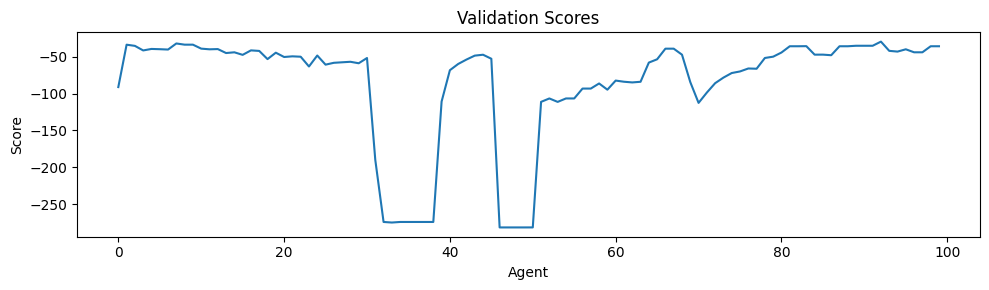

In [15]:
# Plot scores_all
fig = plt.figure(figsize=(10, 3))
plt.plot(np.arange(len(scores_all)), scores_all)
plt.ylabel('Score')
plt.xlabel('Agent')
plt.title('Validation Scores')

plt.show()

In [16]:
# Print the maximum 10 scores
scores_all = np.array(scores_all)
max_scores = np.sort(scores_all)[-10:]
print(max_scores)
# Print their indices
max_scores_indices = np.argsort(scores_all)[-10:]
print(max_scores_indices+1)

[-35.52914967 -35.12517913 -34.99170619 -34.98951818 -34.98951818
 -33.53342565 -33.49741089 -33.49741089 -31.87210644 -29.36901777]
[84  3 92 90 91  2 10  9  8 93]
